# Applied Data Science (MAST30034) Tutorial 3

`statsmodels` (30-45 minutes):
- Linear Regression
- Evaluation Metrics
- Penalized Regression (LASSO and Ridge)

`pyspark.ml` (Experimental) (15 minutes):
- Linear Regression

Project 1 Report (Remainder of Tutorial):
- Questions
- Ongoing feedback.

Optional Content for Students:
- General Revision on important ML concepts
- Generalised Linear Models (GLM) with `statsmodels`
- Discussion Questions / Homework with Solutions released next week
_________________

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.formula.api import ols, glm

In [4]:
df = pd.read_parquet("../../data/tute_data/sample_data.parquet")
df.dtypes

VendorID                          int32
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                      int32
DOLocationID                      int32
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
Airport_fee                     float64
dtype: object

As an example, let's try to predict `total_amount` using `fare_amount, tip_amount, toll_amount, trip_distance, VendorID` as predictors.

Some things to take note:
- `tip_amount` is only valid for `payment_type == 1` (card)
- `VendorID` is categorical, with only two possible values (`1` or `2`) so we should make it boolean

**Whilst you may use this as an example, please do not copy this as it is incorrect.**

How so? Discuss as a class the implications of predicting `total_amount` given the feature space.

In [5]:
# filter dataframe
COL_FILTER = ['total_amount', 'fare_amount', 'tip_amount', 'tolls_amount', 'trip_distance', 'VendorID']
df_filtered = df.loc[df['payment_type'] == 1, COL_FILTER].reset_index(drop=True)

df_filtered['VendorID'] = df_filtered['VendorID'] == 1 

df_filtered.tail()

,total_amount,fare_amount,tip_amount,tolls_amount,trip_distance,VendorID
115878,19.58,12.8,1.78,0.0,1.51,False
115879,18.40,11.4,2.00,0.0,1.71,False
115880,14.64,7.2,2.44,0.0,1.02,False
115881,18.75,10.0,3.75,0.0,1.19,False
115882,15.70,10.7,0.00,0.0,1.60,True


- We are looking for linear relationships between our chosen response `total_amount`.   
- Now I'm not sure what kind of life you've lived, but I'm fairly certain that we can infer that `total_amount` will have a positive linear relationship with `fare_amount`. Let's see a quick plot...

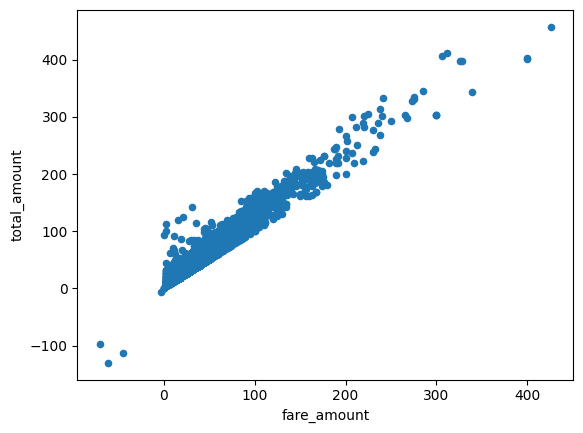

In [6]:
df_filtered[['total_amount', 'fare_amount']].plot.scatter(x='fare_amount', y='total_amount')
plt.show()

Well, obviously this looks like an overall positive linear relationship. How might we statistically test this?

-------

In `R`, we would do something like this for (Ordinary) Least Squares:
```R
>>> fit <- lm(total_amount~fare_amount + tip_amount + tolls_amount + trip_distance + VendorID ,data=dat_fit)
>>> summary(fit)
```
```
Call:
lm(formula = total_amount ~ fare_amount + tip_amount + tolls_amount +
trip_distance + VendorID, data = dat_fit)

Residuals:
Min     1Q      Median  3Q     Max
-1.4727 -0.3295 -0.1528 0.1747 1.7975

Coefficients:
               Estimate Std. Error t value Pr(>|t|)
(Intercept)    1.162154   0.002986 389.194  <2e-16 ***
fare_amount    0.993388   0.000315 3153.943 <2e-16 ***
tip_amount     1.006511   0.000826 1218.553 <2e-16 ***
tolls_amount   0.979325   0.001285 762.428  <2e-16 ***
trip_distance  0.011742   0.000963 12.194   <2e-16 ***
VendorIDTRUE  -0.003125   0.002914 -1.073    0.283
---
Signif. codes:
0 ^a˘A¨Y***^a˘A´Z 0.001 ^a˘A¨Y**^a˘A´Z 0.01 ^a˘A¨Y*^a˘A´Z 0.05 ^a˘A¨Y.^a˘A´Z 0.1 ^a˘A¨Y ^a˘A´Z 1

Residual standard error: 0.362 on 61886 degrees of freedom
Multiple R-squared: 0.9994,          Adjusted R-squared: 0.9994
F-statistic: 1.953e+07 on 5 and 61886 DF, p-value: < 2.2e-16
```

Note: This example from `R` uses an older dataset hence different values to the Python output below.

Documentation Source: https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.html?highlight=ols#statsmodels.regression.linear_model.OLS

In [7]:
fit = ols(
    formula="total_amount ~ fare_amount + tip_amount + tolls_amount + trip_distance + VendorID",
    data=df_filtered
).fit()

In [8]:
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:           total_amount   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 4.778e+06
Date:                Thu, 15 Aug 2024   Prob (F-statistic):               0.00
Time:                        14:26:37   Log-Likelihood:            -2.1529e+05
No. Observations:              115883   AIC:                         4.306e+05
Df Residuals:                  115877   BIC:                         4.307e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            4.8129      0.008  

Discussion Questions:
1. Is this model good? Discuss $R^2$, AIC, and Hypothesis Testing.
    
2. How might we improve this model? Discuss what we can do with the current features / engineered features.


In [9]:
# let's try another model without VendorID
fitter = ols(
    formula="total_amount ~ fare_amount + tip_amount + tolls_amount + trip_distance",
    data=df_filtered
).fit()

print(fitter.summary())

                            OLS Regression Results                            
Dep. Variable:           total_amount   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 5.957e+06
Date:                Thu, 15 Aug 2024   Prob (F-statistic):               0.00
Time:                        14:28:04   Log-Likelihood:            -2.1545e+05
No. Observations:              115883   AIC:                         4.309e+05
Df Residuals:                  115878   BIC:                         4.310e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         4.7626      0.008    606.417

Now that we have to values of AIC to compare with, which one is better...?

In [10]:
fit.aic, fitter.aic, f"abs diff: {abs(fitter.aic - fit.aic)}"

(np.float64(430600.3832931352),
 np.float64(430904.84882629267),
 'abs diff: 304.4655331574613')

In [11]:
[fit.aic, fitter.aic], [fit.bic, fitter.bic]

([np.float64(430600.3832931352), np.float64(430904.84882629267)],
 [np.float64(430658.3453111776), np.float64(430953.15050799464)])

----------

## Penalized Regression
- (From a machine learning perspective) Given a data distribution $\mathcal{D}$, predefined model hypothesis class $\mathcal{B}$, a loss function $\ell$. The goal of machine learning (aka modelling) is to find parameter $\beta^*$ such that,

  $$\beta^* = \text{argmin}_{\beta\in\mathcal{B}} \mathbb{E}_{(x,y)\in \mathcal{D}}\{\ell(y, f_{\beta}(x))\}$$
  
- In reality, we don't have $\mathcal{D}$, but only a dataset $\mathbb{(X, Y)}$ where $(x_i, y_i) \sim \mathcal{D}$. And we empirically compute, 

  $$\hat\beta^* = \text{argmin}_{\beta\in\mathcal{B}} \sum_{(x,y)\in (\mathbb{X, Y})}\ell(y, f_{\beta}(x))$$
  
  In the hope that, $\hat\beta^*$ is close to $\beta^*$. So for any unseen $(x, y) \sim \mathcal{D}$, our model is still optimal.
- This implies that a more complicated $\hat\beta^*$ (blue) might not correspond to actual optimal parameters $\beta^*$ (green).

<img src="../../media/regularization.png" alt="regularization" style="width: 400px;"/>

  - In practice, a simpler model often explains ground truth better. We call the techniques to simplify model *regularization*.
- For linear regression model, LASSO and Ridge are two common techniques to regularize model.


Revision from MAST30025 if you require it:
- Lecture 4 (variable selection)
- LSM topic 5 (`ch05_handout`) slide 141/141

## Penalized Regression
An excellent explanation on Ridge / LASSO: https://www.youtube.com/watch?v=9LNpiiKCQUo (recommended at x1.25 speed). Please watch this in your own time.


### LASSO ($\ell_1$)
- Regularizes coefficient magnitude with $\ell_1$ loss,

  $$\hat\beta^* = \text{argmin}_{\beta \in \mathcal{B}} (\mathbf{y}-X\beta)^T(\mathbf{y}-X\beta) + \lambda  ||\beta||_1$$
  
- LASSO encourages coefficient sparsity (setting to a value of 0).
- Features that are collinear will result in one of them being reduced to 0 coefficient.
- In this sense, it's quite similar to feature selection as you end up with a model that is much more simpler. 


### Ridge ($\ell_2$)
- Regularizes coefficient magnitude with $\ell_2$ loss,

  $$\hat\beta^* = \text{argmin}_{\beta \in \mathcal{B}} (\mathbf{y}-X\beta)^T(\mathbf{y}-X\beta) + \frac{1}{2} \lambda ||\beta||_2^2$$
  
- Ridge regression tend to shrink coefficients to a small value but not zero.
- Maintaining more features, Ridge Regression is less interpretable than LASSO, but performs better in cases where there may be high multi-collinearity (i.e dependencies between attributes) or high linear correlation between certain attributes.
- You must also ensure that we have more observations than attributes (`n > p`) as this penalty method does not drop features unlike LASSO, leading to worse predictions overall. 

<img src="../../media/lasso_ridge.png" alt="lassoridge" style="width: 600px;"/>

### Elastic Net
Quick overview:
- Combines both $\ell_1$ and $\ell_2$ penalty,

  $$\hat\beta^* = \text{argmin}_{\beta \in \mathcal{B}} (\mathbf{y}-X\beta)^T(\mathbf{y}-X\beta) + \lambda_1 ||\beta||_1 + \frac{1}{2} \lambda_2 ||\beta||_2^2$$
  
- Python implementation (glmnet):
  - https://github.com/civisanalytics/python-glmnet/blob/master/glmnet/linear.py
  - `glmnet`'s implementation (_hyper_)parameterizes the loss using $\alpha$ and $\lambda$,
    $$\hat\beta^* = \text{argmin}_{\beta \in \mathcal{B}} (\mathbf{y}-X\beta)^T(\mathbf{y}-X\beta) + \lambda \{\alpha ||\beta||_1 + \frac{1}{2} (1-\alpha) ||\beta||_2^2\}$$
    
Question: _How would you set the parameters if you want LASSO only? Likewise, what about for Ridge?_  
- If you are unsure, what values of $\alpha$ will give us the same equation as LASSO or Ridge?

In [14]:
y_cols = ['total_amount']
x_cols = ['fare_amount', 'tip_amount', 'tolls_amount', 'trip_distance', 'VendorID']

# standardize (by calculating the zscore) so our data has mean 0 and var 1
# alternatively, you can use sklearn's StandardScalar
from scipy.stats import zscore

df_standard = df_filtered[x_cols].astype(float).apply(zscore)

In [15]:
# format output to 4 decimal places
pd.options.display.float_format = '{:,.4f}'.format
df_standard.describe().loc[['mean','std']]

,fare_amount,tip_amount,tolls_amount,trip_distance,VendorID
mean,-0.0000,-0.0000,0.0000,-0.0000,-0.0000
std,1.0000,1.0000,1.0000,1.0000,1.0000


As you can see, `df_standard` has  $\mu=0, \sigma=1(=\sigma^2)$  

You will need to `pip3 install glmnet` or `conda install -c conda-forge glmnet` below if you would like to use this implementation. If you are pip installing, `glmnet` is only working for `Python3.8` or lower as far as we know. There are alternatives you can use from `sklearn`, though, `glmnet` aims to be a 1:1 implementation of the `R` alternative.

For the example below, we will use `glmnet` to run a LASSO model.

In [16]:
import numpy as np
from glmnet import ElasticNet

elastic_net_model = ElasticNet(alpha=1) 
elastic_net_model.fit(
    df_standard.values, 
    # flatten the array (from 2d matrix to 1d vector) to remove the warning message:
    # A column-vector y was passed when a 1d array was expected.
    df_filtered[y_cols].values.flatten()
)

ModuleNotFoundError: No module named 'glmnet'

Now, we want to look at the shrinking parameter $\lambda$.  

In [13]:
# this can be accessed using the .lambda_best_ method after fitting!
print(f'Best lambda value for LASSO: {elastic_net_model.lambda_best_[0]}')

Best lambda value for LASSO: 2.332278727877255


$\lambda$ for `ElasticNet` is computed by using cross validation (iterative approach). 

What about our coefficients?
- https://github.com/civisanalytics/python-glmnet/blob/master/glmnet/linear.py

In [14]:
pd.DataFrame(
    index=['Intercept'] + x_cols, 
    data=[elastic_net_model.intercept_] + list(elastic_net_model.coef_), 
    columns=['Coefficient']
)

,Coefficient
Intercept,28.3224
fare_amount,16.2869
tip_amount,3.1294
tolls_amount,1.2422
trip_distance,0.0000
VendorID,0.0000


Discuss the results.

If you want to run predictions with `ElasticNet`, you can use `elastic_net_model.predict(x)` to the predict a new set of observations by passing through the `x` matrix.

___________________

## Linear Regression with Spark
Whilst using `sklearn` or `statsmodels` can be easier on a smaller sample size, using the full dataset can be quite memory intensive. For those looking to use larger datasets, using the `pyspark.ml` library may prove useful.

We'll go back to the first linear model example that we did with `statsmodels`.

In [12]:
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder.appName('MAST30034 Tutorial 3')
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config('spark.driver.memory', '4g')
    .config('spark.executor.memory', '2g')
    .getOrCreate()
)

your 131072x1 screen size is bogus. expect trouble
24/08/15 14:31:06 WARN Utils: Your hostname, DESKTOP-F216TKE resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
24/08/15 14:31:06 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/08/15 14:31:06 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [13]:
sdf = spark.read.parquet('../../data/tlc_data/raw/*')

Like correlation from the previous tutorial, we will need to assemble a single vector for `pyspark.ml` to work. Since `pyspark.ml` is still experimental in development stage, it's unable to handle `NULL` values. 

We will simply drop them here using `sdf.dropna('any')` where the `'any'` argument specifies to drop an instance if any field is `NULL`). For your Project 1, you should justify it with a reason (i.e _"Since Spark ML wasn't able to handle `NULL` values, we decided to drop it."_)

In [17]:
# VectorAssembler creates new vectors from existing columns
from pyspark.ml.feature import VectorAssembler

features = 'features'
input_cols = ['fare_amount', 'tip_amount', 'tolls_amount', 'trip_distance', 'VendorID']

assembler = VectorAssembler(
    # which column to combine
    inputCols=input_cols, 
    # How should the combined columns be named
    outputCol=features
)

model_sdf = assembler.transform(sdf.dropna('any'))
# Display the features and targets for our model
model_sdf.select('features').head(5), model_sdf.select('total_amount').head(5)

([Row(features=DenseVector([17.7, 0.0, 0.0, 1.72, 2.0])),
  Row(features=DenseVector([10.0, 3.75, 0.0, 1.8, 1.0])),
  Row(features=DenseVector([23.3, 3.0, 0.0, 4.7, 1.0])),
  Row(features=DenseVector([10.0, 2.0, 0.0, 1.4, 1.0])),
  Row(features=DenseVector([7.9, 3.2, 0.0, 0.8, 1.0]))],
 [Row(total_amount=22.7),
  Row(total_amount=18.75),
  Row(total_amount=31.3),
  Row(total_amount=17.0),
  Row(total_amount=16.1)])

You'll start to notice that the PySpark API mirrors `sklearn`, hopefully, this doesn't seem to foreign.

Pyspark Docs: https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.regression.LinearRegression.html

This implementation supports both OLS, Ridge, LASSO, and Elastic Net. You can change between the models by specifying the `elasticNetParam`.

In [18]:
from pyspark.ml.regression import LinearRegression

lm = LinearRegression(
    featuresCol='features', 
    labelCol='total_amount'
).fit(model_sdf)

24/08/15 14:37:38 WARN Instrumentation: [100c1906] regParam is zero, which might cause numerical instability and overfitting.


In [19]:
# Access coefficients
pd.DataFrame(
    data=[lm.intercept] + list(lm.coefficients),
    index=['intercept'] + input_cols,
    columns=['coefficient']
)

,coefficient
intercept,4.2251
fare_amount,1.0094
tip_amount,1.0860
tolls_amount,1.1598
trip_distance,-0.0002
VendorID,0.0194


Let's go through a single prediction from the record above.

In [21]:
# example record to predict
sdf.select('total_amount', *input_cols).limit(1).show(vertical=True)

-RECORD 0-------------
 total_amount  | 22.7 
 fare_amount   | 17.7 
 tip_amount    | 0.0  
 tolls_amount  | 0.0  
 trip_distance | 1.72 
 VendorID      | 2    



In [25]:
# preprocess for predictions
predict_test = sdf.select(*input_cols).limit(1)

assembler = VectorAssembler(
    inputCols=input_cols, 
    outputCol=features
)

predict_sdf = assembler.transform(predict_test).select(features)

predict_sdf.show(1, vertical=True)

-RECORD 0------------------------
 features | [17.7,0.0,0.0,1.7... 



Use `lm.transform()` to predict an `sdf` containing a single vector of features as shown above.

In [27]:
predictions = lm.transform(predict_sdf)
predictions.show(vertical=True, truncate=False)

-RECORD 0-----------------------------
 features   | [17.7,0.0,0.0,1.72,2.0] 
 prediction | 22.130620133290265      



Let's look at the original record and compare the prediction vs true value.

For evaluation metrics, you can use the `.summary` method. See https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.regression.LinearRegressionModel.html?highlight=ml%20summary%20regression#pyspark.ml.regression.LinearRegressionModel.summary

In [28]:
# r2 example
lm.summary.r2

0.9935079137872085

In [29]:
# if you want to see the definitive list of all evaluation metrics accessible from lm.summary
help(lm.summary)

Help on LinearRegressionTrainingSummary in module pyspark.ml.regression object:

class LinearRegressionTrainingSummary(LinearRegressionSummary)
 |  LinearRegressionTrainingSummary(java_obj: Optional[ForwardRef('JavaObject')] = None)
 |  
 |  Linear regression training results. Currently, the training summary ignores the
 |  training weights except for the objective trace.
 |  
 |  .. versionadded:: 2.0.0
 |  
 |  Method resolution order:
 |      LinearRegressionTrainingSummary
 |      LinearRegressionSummary
 |      pyspark.ml.wrapper.JavaWrapper
 |      builtins.object
 |  
 |  Readonly properties defined here:
 |  
 |  objectiveHistory
 |      Objective function (scaled loss + regularization) at each
 |      iteration.
 |      This value is only available when using the "l-bfgs" solver.
 |      
 |      .. versionadded:: 2.0.0
 |      
 |      See Also
 |      --------
 |      LinearRegression.solver
 |  
 |  totalIterations
 |      Number of training iterations until termination.
 |

24/08/15 20:29:29 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 727458 ms exceeds timeout 120000 ms
24/08/15 20:29:29 WARN SparkContext: Killing executors is not supported by current scheduler.
24/08/15 20:29:30 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$

----

## Consultation and Questions for Project 1
If you would like to ask feedback for your approach and/or report, feel free to ask your tutor to assist if time permits.

----

## (Optional) General Notes for Revision
#### What is the Bias-Variance tradeoff with respect to linear models:
- Less parameters = less variance but more bias
- More parameters = more variance but less bias
- The goal depends on the problem, but generally we want an even variance and bias (intersection).


#### Is using regression on X attribute / specific dataset even a good choice...?
- The answer is yes, it is a good choice *to try*
- BUT also try other methods...


#### What are the pros and cons of stepwise regression?
- Forward Selection (start from nothing and end until significant)
- Backward Elimination (start with everything and end until no more can be removed)
- Not always the best results...


#### What is best subset regression and the pros and cons of it?
- A brute-force like method of fitting *all possible regressions* or *all possible models*
- Unlike stepwise, this method fits all possible models based on the variables specified, so you will get the best model possible
![a_secret_easter_egg_i_like_apples](https://i.kym-cdn.com/photos/images/newsfeed/001/718/138/147.jpg)



#### What is an assumption we make when we fit linear regression models?
- Make sure the input matrix is full rank.
  - Question: _What happens when input matrix is not full rank?_
- Well, the data has to be linearly separable. 
- Does this also apply to other models too...? (Recall SVM and kernel function which we can use)
- Perhaps another model might suit the dataset... (Trees, Neural Networks, Clustering, etc...)


#### If you were to use a decision tree, how would you compare between two different fits? 
- Look at Gini Impurity (probability of an incorrectly classified instance)


#### How about baselines or other predictive machine learning models?
- Precision, Recall, Classification Accuracy...
---

## (Optional) Fitting a GLM with Python
**Since MAST30027 is not a pre-requisuite, we will not cover this nor do we expect students to use GLMs. However, those who wish to experiment with GLMs using Python may go through this section.**

Let's go through an example:
- The `passenger_count` attribute is discrete and non-negative. If we were to predict it, a linear model will not be sufficient. 
- We know that a Poisson distribution takes in non-negative integer values, so we can use the Poisson family of GLMs to model this. 
- We will use `total_amount, trip_distance, VendorID` as our regressors.

Summary:
- GLM's allow us to express relationships in a linear and additive way like normal linear regression.
- However, it might be the case that the underlying true relationship is neither linear nor additive. 
- The transformation is done through a *link function* (in this case, Poisson).

Why would we use try and use Poisson? The distribution of `passenger_count` is frequency based greater than 0.

In [25]:
from statsmodels.api import families

# convert VendorID to categorical
df['VendorID'] = df['VendorID'] == 1

# statsmodels glm
fit = glm(
    formula="passenger_count ~ total_amount + trip_distance + VendorID",
    data=df, 
    family=families.Poisson()
).fit()

print(fit.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:        passenger_count   No. Observations:               149730
Model:                            GLM   Df Residuals:                   149726
Model Family:                 Poisson   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.9351e+05
Date:                Mon, 24 Jul 2023   Deviance:                       64654.
Time:                        13:59:06   Pearson chi2:                 8.58e+04
No. Iterations:                     5   Pseudo R-squ. (CS):           0.006764
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.3262      0.004  

## (Optional) Discussion Questions
These are some optional class discussion questions or left as extra study materials. Feel free to come back to these after this subject - these are common interview questions for Data Science.

1. What is formula of $f_{\beta}(x)$, $\ell(\cdot, \cdot)$ for linear regression?

    1. Can you also define them for LASSO/Ridge regressions?


2. Ridge Regression tends to penalize coefficients to a small value, but, not zero. Can you explain this?
    - Tip: consider a pair of positive coefficient $\beta=[1, \epsilon], \epsilon < 1$, and think about what happens to $||\beta||_2^2$ when you subtract $\delta \leq \epsilon$ from each element $\beta$
    

3. How would you implement optimizer for the following models: LASSO, Ridge, Elastic Net?

4. When using penalised regression models, do you need to standardize the input? Why?

5. Is the following pseudo-code correct? Why or why not?

```R
mu <- mean(X)
sigma <- std(X)

X_std <- (X - mu) / sigma
X_train, X_test, y_train, y_test <- split(X_std, y)

model <- fit(y_train ~ X_train)
y_pred <- predict(model, X_test)

loss <- MSE(y_test, y_pred)

```